Importamos las librerias. Algunas son para el uso de la GPU, otras son para el proyecto

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import subprocess
import cv2
from tensorflow.keras.callbacks import EarlyStopping



In [21]:
import tensorflow as tf
# Verificar si TensorFlow detecta GPU
if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU detectada:')
    for device in tf.config.list_physical_devices('GPU'):
        print(device)
else:
    print('No se detectó GPU. Se utilizará la CPU.')

GPU detectada:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Para que el programa utilice la VRAM que tiene el sistema y no la RAM de la computadora

In [22]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")

Cantidad total de memoria VRAM en la GPU: 6.0 GB


Leer la base de datos creada con anterioridad y ver su contenido

In [23]:
df = pd.read_hdf('BD_Emotions_FER.h5')

In [24]:
df.head()

,Imagen,Caracteristicas,Rostro,Etiqueta
0,"[[178, 178, 183, 188, 193, 197, 201, 205, 208,...","[[13, 56], [16, 73], [20, 89], [27, 103], [36,...","[[161, 168, 171, 174, 175, 173, 171, 170, 168,...",surprise
1,"[[87, 87, 88, 90, 92, 86, 78, 71, 65, 60, 54, ...","[[9, 56], [10, 73], [12, 90], [15, 106], [21, ...","[[100, 101, 101, 102, 108, 120, 132, 141, 140,...",surprise
2,"[[183, 183, 184, 185, 186, 182, 178, 173, 169,...","[[6, 68], [6, 85], [8, 102], [12, 117], [17, 1...","[[96, 100, 110, 119, 131, 145, 159, 169, 169, ...",surprise
3,"[[251, 251, 250, 250, 250, 250, 249, 249, 227,...","[[29, 76], [34, 90], [40, 103], [49, 114], [59...","[[78, 98, 121, 144, 161, 172, 182, 189, 191, 1...",surprise
4,"[[252, 252, 252, 252, 252, 252, 252, 252, 252,...","[[32, 73], [33, 85], [35, 97], [39, 110], [43,...","[[239, 183, 124, 65, 47, 37, 28, 32, 42, 52, 6...",surprise


Separamos las caracteristicas y etiquetas

In [25]:
# Separar las características y etiquetas
X = np.array(df['Rostro'])
y = df['Etiqueta']

Verificamos el formato, que sea ideal para la CNN

In [26]:
print(df['Imagen'].values[0].shape)
print(df['Rostro'].values[1].shape)

(150, 150)
(126, 129)


Dado que el formato de rostro puede ser menor o mayor medida, hay que adaptar todos los datos a un formato. En este caso lo escalamos a 150x150

In [27]:
for i in range(X.shape[0]):
    X[i] = np.array(Image.fromarray(X[i]).resize((150,150)))
    X[i] = np.expand_dims(X[i], axis=-1)

Verificamos el formato 

In [28]:
print(X[0].shape)

(150, 150, 1)


Codificamos el formato de las etiquetas para que estén en 0,1,2,3,4,5...

In [29]:
# Codificar las etiquetas
etiquetas = y.unique()
etiquetas.sort()
print("Etiquetas únicas ordenadas:", etiquetas)
y_encoded = pd.Categorical(y, categories=etiquetas,ordered=True).codes
print("Etiquetas codificadas:", y_encoded)

Etiquetas únicas ordenadas: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Etiquetas codificadas: [6 6 6 ... 2 2 2]


Hacemos los datos de entrenamiento y los de prueba

In [30]:
# Dividir el dataset en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, 
                                                  stratify=y_encoded,
                                                  random_state=42)

Transformar las etiquetas a one_hot. Dependiendo la posición del numero es la etiqueta 

In [31]:
# Convertir las etiquetas a formato one-hot con el número correcto de clases
num_classes = len(etiquetas)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

print("Etiquetas en formato one-hot (entrenamiento):", y_train_one_hot)
print("Etiquetas en formato one-hot (validación):", y_val_one_hot)
print("Clases originales:", etiquetas)

Etiquetas en formato one-hot (entrenamiento): [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
Etiquetas en formato one-hot (validación): [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Clases originales: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


Distribución visual de las etiquetas y su clasificacion

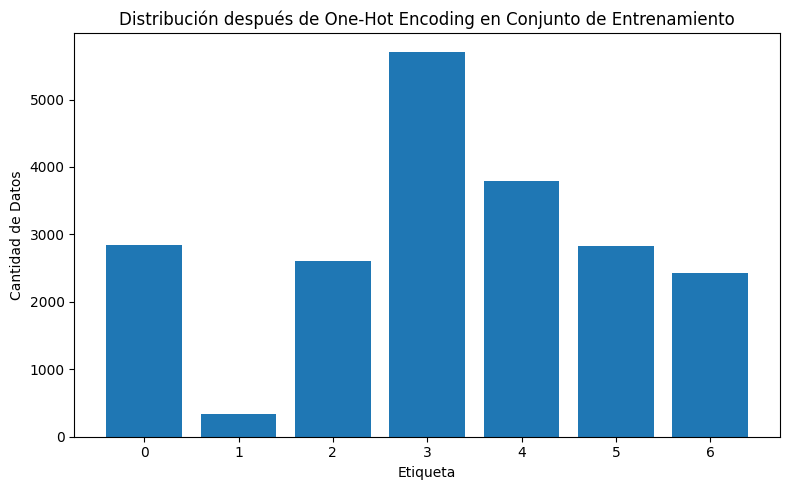

In [32]:
# Visualizar la distribución después de convertir las etiquetas a one-hot
plt.figure(figsize=(8, 5))
plt.bar(np.unique(y_train_one_hot.argmax(axis=1)), np.bincount(y_train_one_hot.argmax(axis=1)), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución después de One-Hot Encoding en Conjunto de Entrenamiento')
plt.tight_layout()
plt.show()

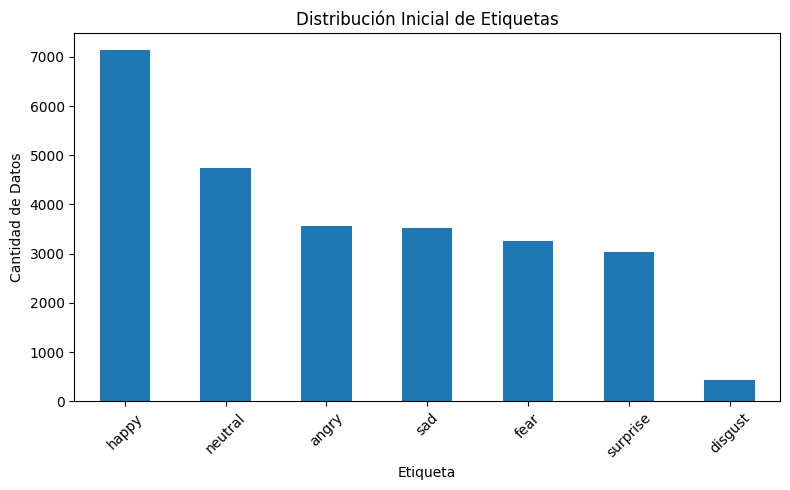

In [33]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df['Etiqueta'].value_counts().plot(kind='bar')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Normalizamos los datos de entrenamiento y los de valores para verificar en numpy array

In [34]:
# Convertir las imágenes a arrays numpy y normalizarlas
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])

Todos los datos de entrenamiento los ponemos en tipo flotante 32 y lo dividimos en 255 (que es formato de imagen), esto para normalizar del 0 al 1

In [35]:
# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

Generamos infinidad de imagenes (Muchas imagenes. No son infinitas). Definimos los patrones para generar más imagenes y que el modelo no se sobre ajuste

In [36]:
# Definir el generador de imágenes para aumentar el dataset de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



Aqui lo aumentamos.

In [37]:
# Aumentar el dataset de entrenamiento utilizando el generador de imágenes
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=28)


Todo el modelo definido

In [47]:
# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(528, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(etiquetas), activation='softmax')  # Capa de salida con activación softmax
])



/home/waldos/.local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilamos el modelo.

In [48]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Entrenamos el modelo

In [49]:
# Definir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [50]:
# Entrenar el modelo con el callback de TensorBoard
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                    epochs=45,
                    validation_data=(X_val, y_val_one_hot),
                    verbose=1,
                    callbacks=[early_stopping]
                    )


Epoch 1/45


2024-05-23 07:17:26.388446: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 07:17:27.884568: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 07:17:28.693055: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 07:17:28.693093: W external/local_tsl/tsl/framework/bfc_

235/734 ━━━━━━━━━━━━━━━━━━━━ 51s 103ms/step - accuracy: 0.2428 - loss: 1.8555

2024-05-23 07:18:02.983677: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 07:18:04.166439: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


734/734 ━━━━━━━━━━━━━━━━━━━━ 116s 138ms/step - accuracy: 0.2598 - loss: 1.8288 - val_accuracy: 0.2776 - val_loss: 1.8001
Epoch 2/45
734/734 ━━━━━━━━━━━━━━━━━━━━ 88s 119ms/step - accuracy: 0.2741 - loss: 1.8054 - val_accuracy: 0.2916 - val_loss: 1.7558
Epoch 3/45
734/734 ━━━━━━━━━━━━━━━━━━━━ 92s 125ms/step - accuracy: 0.2899 - loss: 1.7626 - val_accuracy: 0.3095 - val_loss: 1.7065
Epoch 4/45
364/734 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - accuracy: 0.3072 - loss: 1.7264

Guardamos el modelo

In [42]:
# Guardar el modelo
model.save('modelo_cnn_EstratificadoV2.h5')

Obtenemos predicciones del conjunto de validacion

In [43]:
# Obtener las predicciones del conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


Tabla graficamente de la precision y perdida del modelo a partir de las epocas

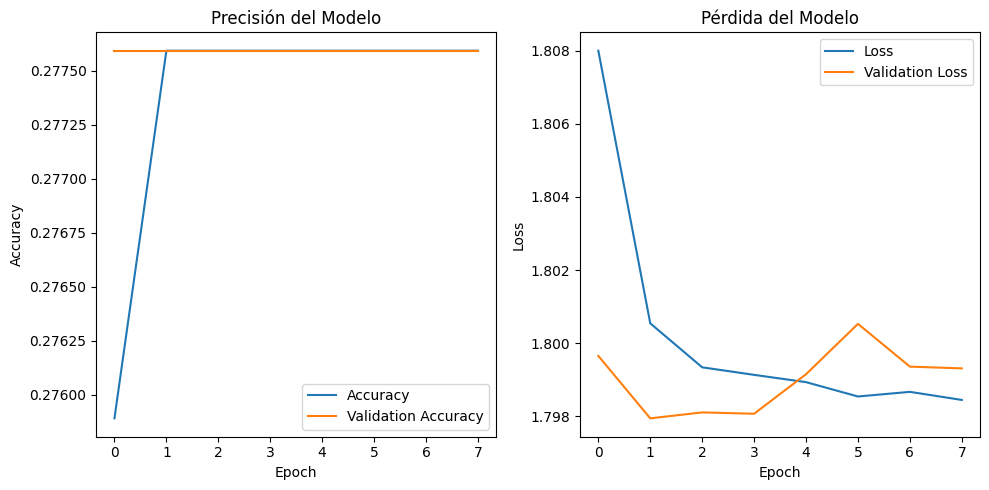

In [44]:
# Mostrar la precisión y pérdida del modelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Modelo')

plt.tight_layout()
plt.show()

Matriz de confusion

In [45]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(np.argmax(y_val_one_hot, axis=1), y_pred_classes)

Visualizacion de la matriz de confusion mediante mapa de calor

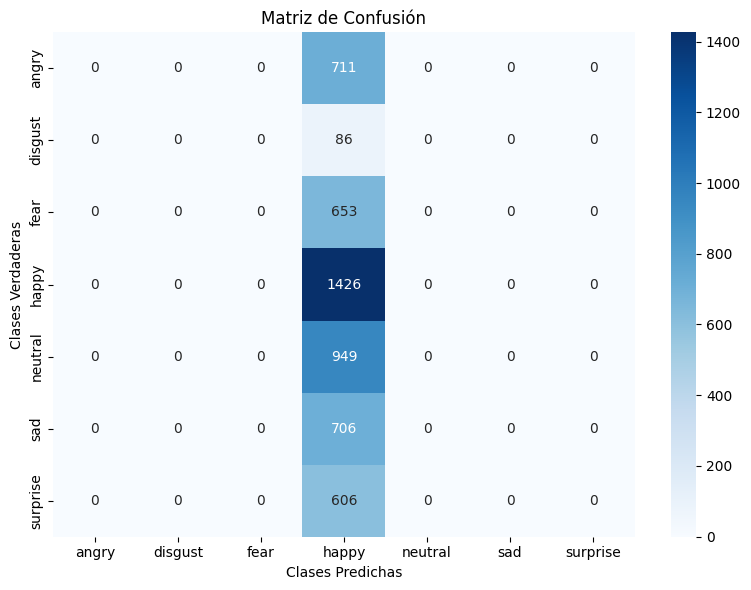

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [46]:
# Visualizar la matriz de confusión como un mapa de calor
clases_originales = ['angry' ,'disgust' ,'fear' ,'happy', 'neutral' ,'sad' ,'surprise']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=clases_originales, yticklabels=clases_originales)
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()
print(clases_originales)